In [1]:
import gseapy as gp
from gseapy.plot import barplot, dotplot
import json
import pandas as pd
import numpy as np

### Import ADR-target dict and get the withdrawl drugs off-target prediction results

In [2]:
adr_target_dict = json.load(open('/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/data/ADR_target/filtered_358items_lessthan3.json','rb'))
print(len(adr_target_dict))

# count off-targets number in ADR-target dict 
adr_target_num = {}
target_list = []
for key,value in adr_target_dict.items():
    adr_target_num[key] = len(value)
    target_list.extend(value)

print("Related off-targets number is {}".format(len(set(target_list))))

358
Related off-targets number is 193


In [3]:
drug_prediction_df_o = pd.read_csv('/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/data/withdrawal_data/withdrawal_toxic_prediction.csv')
target_list_save = list(set(target_list))
print("Saved off-targets number is {}".format(len(set(target_list_save))))

#Rebuild drug_prediction_df according to target_list_save, that is, keep only the target column in target_list_save
print("Before filtering columns, data shape is {}".format(drug_prediction_df_o.shape))
target_list_save.insert(0, 'smiles')

drug_prediction_df_n = drug_prediction_df_o[target_list_save]
print("After filtering columns, data shape is {}".format(drug_prediction_df_n.shape))

# drug_prediction_df_n.to_csv('/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/data/withdrawal_data/drug_withdrawal_193offtarget_predict.csv', index=False)

Saved off-targets number is 193
Before filtering columns, data shape is (408, 243)
After filtering columns, data shape is (408, 194)


### Obtain off-target prediction results for drugs

In [4]:
import pandas as pd
drug_prediction_df = pd.read_csv('/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/data/withdrawal_data/drug_withdrawal_193offtarget_predict.csv')
print(drug_prediction_df.shape)

(408, 194)


### Obtain the differential genes for each drug from the off-target prediction results

In [5]:
drug_list = ['pergolide','phenylpropanolamine','sibutramine','sertindole']
smiles_list = ['CCCN1C[C@H](CSC)C[C@@H]2C3=C4C(=CNC4=CC=C3)C[C@H]21','CC(N)C(O)C1=CC=CC=C1',
               'CC(C)CC(N(C)C)C1(C2=CC=C(Cl)C=C2)CCC1','O=C1NCCN1CCN1CCC(C2=CN(C3=CC=C(F)C=C3)C3=C2C=C(Cl)C=C3)CC1']

for drug, smiles in zip(drug_list, smiles_list):
    print("Now process drug is {}".format(drug))
    drug_df = drug_prediction_df[drug_prediction_df['smiles'] == smiles]

    target_column_names = drug_df.columns[1:][drug_df.iloc[0][1:] >= 0.3]

    target_different = list(target_column_names)
    print("Drug {}'s differential genes number is {}".format(drug, len(target_different)))

    # write the differential genes to .txt file
    with open(f'/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/data/different_target/193target_0.3cut/{drug}_different_target.txt', 'w') as f:
        for item in target_different:
            f.write("%s\n" % item)

Now process drug is pergolide
Drug pergolide's differential genes number is 83
Now process drug is phenylpropanolamine
Drug phenylpropanolamine's differential genes number is 29
Now process drug is sibutramine
Drug sibutramine's differential genes number is 68
Now process drug is sertindole
Drug sertindole's differential genes number is 77


### Get the enrichment analysis results according to ADR-target dict and differential gene of each drug

In [7]:
import numpy as np
for drug in drug_list:
    print("Now process drug is {}".format(drug))
    gene_list = f'/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/data/different_target/193target_0.3cut/{drug}_different_target.txt'

    enr_indoramin = gp.enrichr(gene_list=gene_list,
                            gene_sets=adr_target_dict,
                            # organism='human',
                            outdir='/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/result',
                            cutoff=0.5, # test dataset, use lower value from range(0,1)
                            # top_term=5,
                            # format='png',
                            )
    print(enr_indoramin.res2d.head())

    df_adr_i = enr_indoramin.res2d[['Term','Adjusted P-value']]
    df_adr_i['logp'] = -np.log10(df_adr_i['Adjusted P-value']) 
    # According to -log10(Adjusted P-value), it is sorted from large to small, that is, the corresponding p-value is adjusted from small to large. 
    # The smaller the p-value, the more significant it is
    df_adr_i.sort_values(by='logp',ascending=False,inplace=True) 
    df_adr_i.to_csv(f'/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/result/193target_0.3cut/adr_{drug}_pvalue.csv',index=False)

Now process drug is pergolide
   Gene_set                  Term Overlap   P-value  Adjusted P-value  \
0  gs_ind_0  Abdominal distension     1/8  0.990060          0.998301   
1  gs_ind_0        Abdominal pain    6/11  0.312048          0.524717   
2  gs_ind_0        Abnormal feces     1/4  0.896966          0.994954   
3  gs_ind_0              Acidosis     4/7  0.347644          0.559623   
4  gs_ind_0                  Acne    3/11  0.922424          0.998301   

   Odds Ratio  Combined Score  \
0    0.396791        0.003964   
1    1.330996        1.550077   
2    0.765657        0.083256   
3    1.407547        1.487179   
4    0.689981        0.055716   

                                               Genes  
0                                        HTR3A_10116  
1  CHRM1_10116;HRH1_10116;CHRM1_9606;HRH1_10141;H...  
2                                        HTR3A_10116  
3     CHRM1_10116;CHRM1_9606;CHRM2_10116;CHRM3_10116  
4              SLC6A3_10090;SLC6A3_10116;SLC6A3_9606  
No

/tmp/ipykernel_20636/1064098799.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adr_i['logp'] = -np.log10(df_adr_i['Adjusted P-value'])
/tmp/ipykernel_20636/1064098799.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adr_i.sort_values(by='logp',ascending=False,inplace=True)


   Gene_set             Term Overlap   P-value  Adjusted P-value  Odds Ratio  \
0  gs_ind_0   Abdominal pain    1/11  0.841743          0.961195    0.835240   
1  gs_ind_0             Acne    3/11  0.217831          0.591524    2.095980   
2  gs_ind_0  Agranulocytosis     2/6  0.222552          0.591524    2.622378   
3  gs_ind_0        Akathisia    6/26  0.171399          0.543697    1.748294   
4  gs_ind_0      Amenorrhoea    1/14  0.906276          0.967453    0.651543   

   Combined Score                                              Genes  
0        0.143896                                         HRH1_10116  
1        3.194346              SLC6A3_10090;SLC6A3_10116;SLC6A3_9606  
2        3.940371                               HRH1_10116;DRD1_9823  
3        3.083572  ADRB2_10116;HTR2A_9823;ADRB2_10141;HRH1_10116;...  
4        0.064119                                          DRD1_9823  
Now process drug is sibutramine


/tmp/ipykernel_20636/1064098799.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adr_i['logp'] = -np.log10(df_adr_i['Adjusted P-value'])
/tmp/ipykernel_20636/1064098799.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adr_i.sort_values(by='logp',ascending=False,inplace=True)


   Gene_set             Term Overlap   P-value  Adjusted P-value  Odds Ratio  \
0  gs_ind_0   Abdominal pain    5/11  0.334398          0.721136    1.374529   
1  gs_ind_0         Acidosis     5/7  0.053833          0.222508    2.153806   
2  gs_ind_0             Acne    3/11  0.812052          0.956724    0.847992   
3  gs_ind_0  Agranulocytosis     3/6  0.356342          0.755324    1.541398   
4  gs_ind_0        Akathisia    9/26  0.608683          0.920447    1.009196   

   Combined Score                                              Genes  
0        1.505692  CHRM1_10116;HRH1_10116;CHRM1_9606;CHRM3_10116;...  
1        6.293152  CHRM1_10116;CHRM2_9606;CHRM1_9606;CHRM3_10116;...  
2        0.176545              SLC6A3_10090;SLC6A3_10116;SLC6A3_9606  
3        1.590511                    HRH1_10116;DRD1_10116;DRD1_9823  
4        0.501023  HTR7_10116;DRD2_9606;DRD2_9913;CHRM2_9606;HRH1...  
Now process drug is sertindole


/tmp/ipykernel_20636/1064098799.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adr_i['logp'] = -np.log10(df_adr_i['Adjusted P-value'])
/tmp/ipykernel_20636/1064098799.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adr_i.sort_values(by='logp',ascending=False,inplace=True)


   Gene_set                  Term Overlap   P-value  Adjusted P-value  \
0  gs_ind_0  Abdominal distension     4/8  0.402216          0.632054   
1  gs_ind_0        Abdominal pain    2/11  0.972752          0.999990   
2  gs_ind_0        Abnormal feces     4/4  0.024152          0.132836   
3  gs_ind_0                  Acne    3/11  0.886746          0.999990   
4  gs_ind_0       Agranulocytosis     3/6  0.453498          0.687036   

   Odds Ratio  Combined Score                                           Genes  
0    1.336134        1.216906  HTR3A_10141;HTR3A_9606;HTR3A_10116;HTR3A_10090  
1    0.525482        0.014517                            HRH1_10116;HRH1_9606  
2    2.578231        9.599763  HTR3A_10141;HTR3A_9606;HTR3A_10116;HTR3A_10090  
3    0.745550        0.089613           SLC6A3_10090;SLC6A3_10116;SLC6A3_9606  
4    1.355188        1.071635                 HRH1_10116;HRH1_9606;DRD1_10116  


/tmp/ipykernel_20636/1064098799.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adr_i['logp'] = -np.log10(df_adr_i['Adjusted P-value'])
/tmp/ipykernel_20636/1064098799.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adr_i.sort_values(by='logp',ascending=False,inplace=True)


### Plot the results of ADR enrichment analysis

In [8]:
# Read the ADR severity score file
import pandas as pd
adr_score_df = pd.read_excel('/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/data/ADR_target/ADR_rank_score.xlsx',sheet_name='Ranked ADRs')
adr_score_dict = dict(zip(adr_score_df['Name'], adr_score_df['Rank score']))
adr_score_dict = {k.lower():v for k,v in adr_score_dict.items()}
print(len(adr_score_dict))
print(adr_score_dict)

2929
{'cardiac arrest': 1.0, 'bone cancer metastatic': 0.982921182242014, 'left ventricular failure': 0.973701585857636, 'hiv infection': 0.971544378814008, 'anal cancer': 0.956512511382446, 'lung cancer metastatic': 0.9552054926909, 'haemorrhage intracranial': 0.951337020065969, 'chronic myeloid leukaemia': 0.951006235584163, 'coma': 0.941615412859184, 'breast cancer': 0.940617004005308, 'multi-organ failure': 0.93915830833919, 'cardiopulmonary failure': 0.938708296443951, 'cardiac death': 0.938535096987996, 'chronic leukaemia': 0.9371020877903, 'cardio-respiratory arrest': 0.93468669778428, 'pulmonary embolism': 0.934410412381753, 'completed suicide': 0.933329614338878, 'metastatic renal cell carcinoma': 0.927304304967687, 'hepatic angiosarcoma': 0.926296883198726, 'anaplastic thyroid cancer': 0.920356617210397, 'ovarian epithelial cancer stage iv': 0.91390811703096, 'sudden cardiac death': 0.911654729283003, 'right ventricular failure': 0.91116433330507, 'aortic aneurysm rupture': 0

##### Pergolide

In [9]:
adr_pergolide_pvalue_df = pd.read_csv('/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/result/193target_0.3cut/adr_pergolide_pvalue.csv')

pergolide_adr_score = {}
for index, row in adr_pergolide_pvalue_df.iterrows():
    adr = row['Term']
    adr_l = adr.lower()
    try:
        score = adr_score_dict[adr_l]
    except:
        score = 0
    pergolide_adr_score[adr] = score

pergolide_adr_score['Heart rate increased'] = adr_score_dict['heart rate irregular']

adr_pergolide_pvalue_df['ADR_score'] = adr_pergolide_pvalue_df['Term'].map(pergolide_adr_score)
adr_pergolide_pvalue_df.head()

,Term,Adjusted P-value,logp,ADR_score
0,Orthostatic hypotension,2.560551e-08,7.591667,0.365974
1,Tachycardia,1.185748e-05,4.926008,0.603479
2,Dependence,1.250913e-04,3.902773,0.175593
3,Hyperhidrosis,1.250913e-04,3.902773,0.223636
4,Extrapyramidal disorder,1.250913e-04,3.902773,0.551964


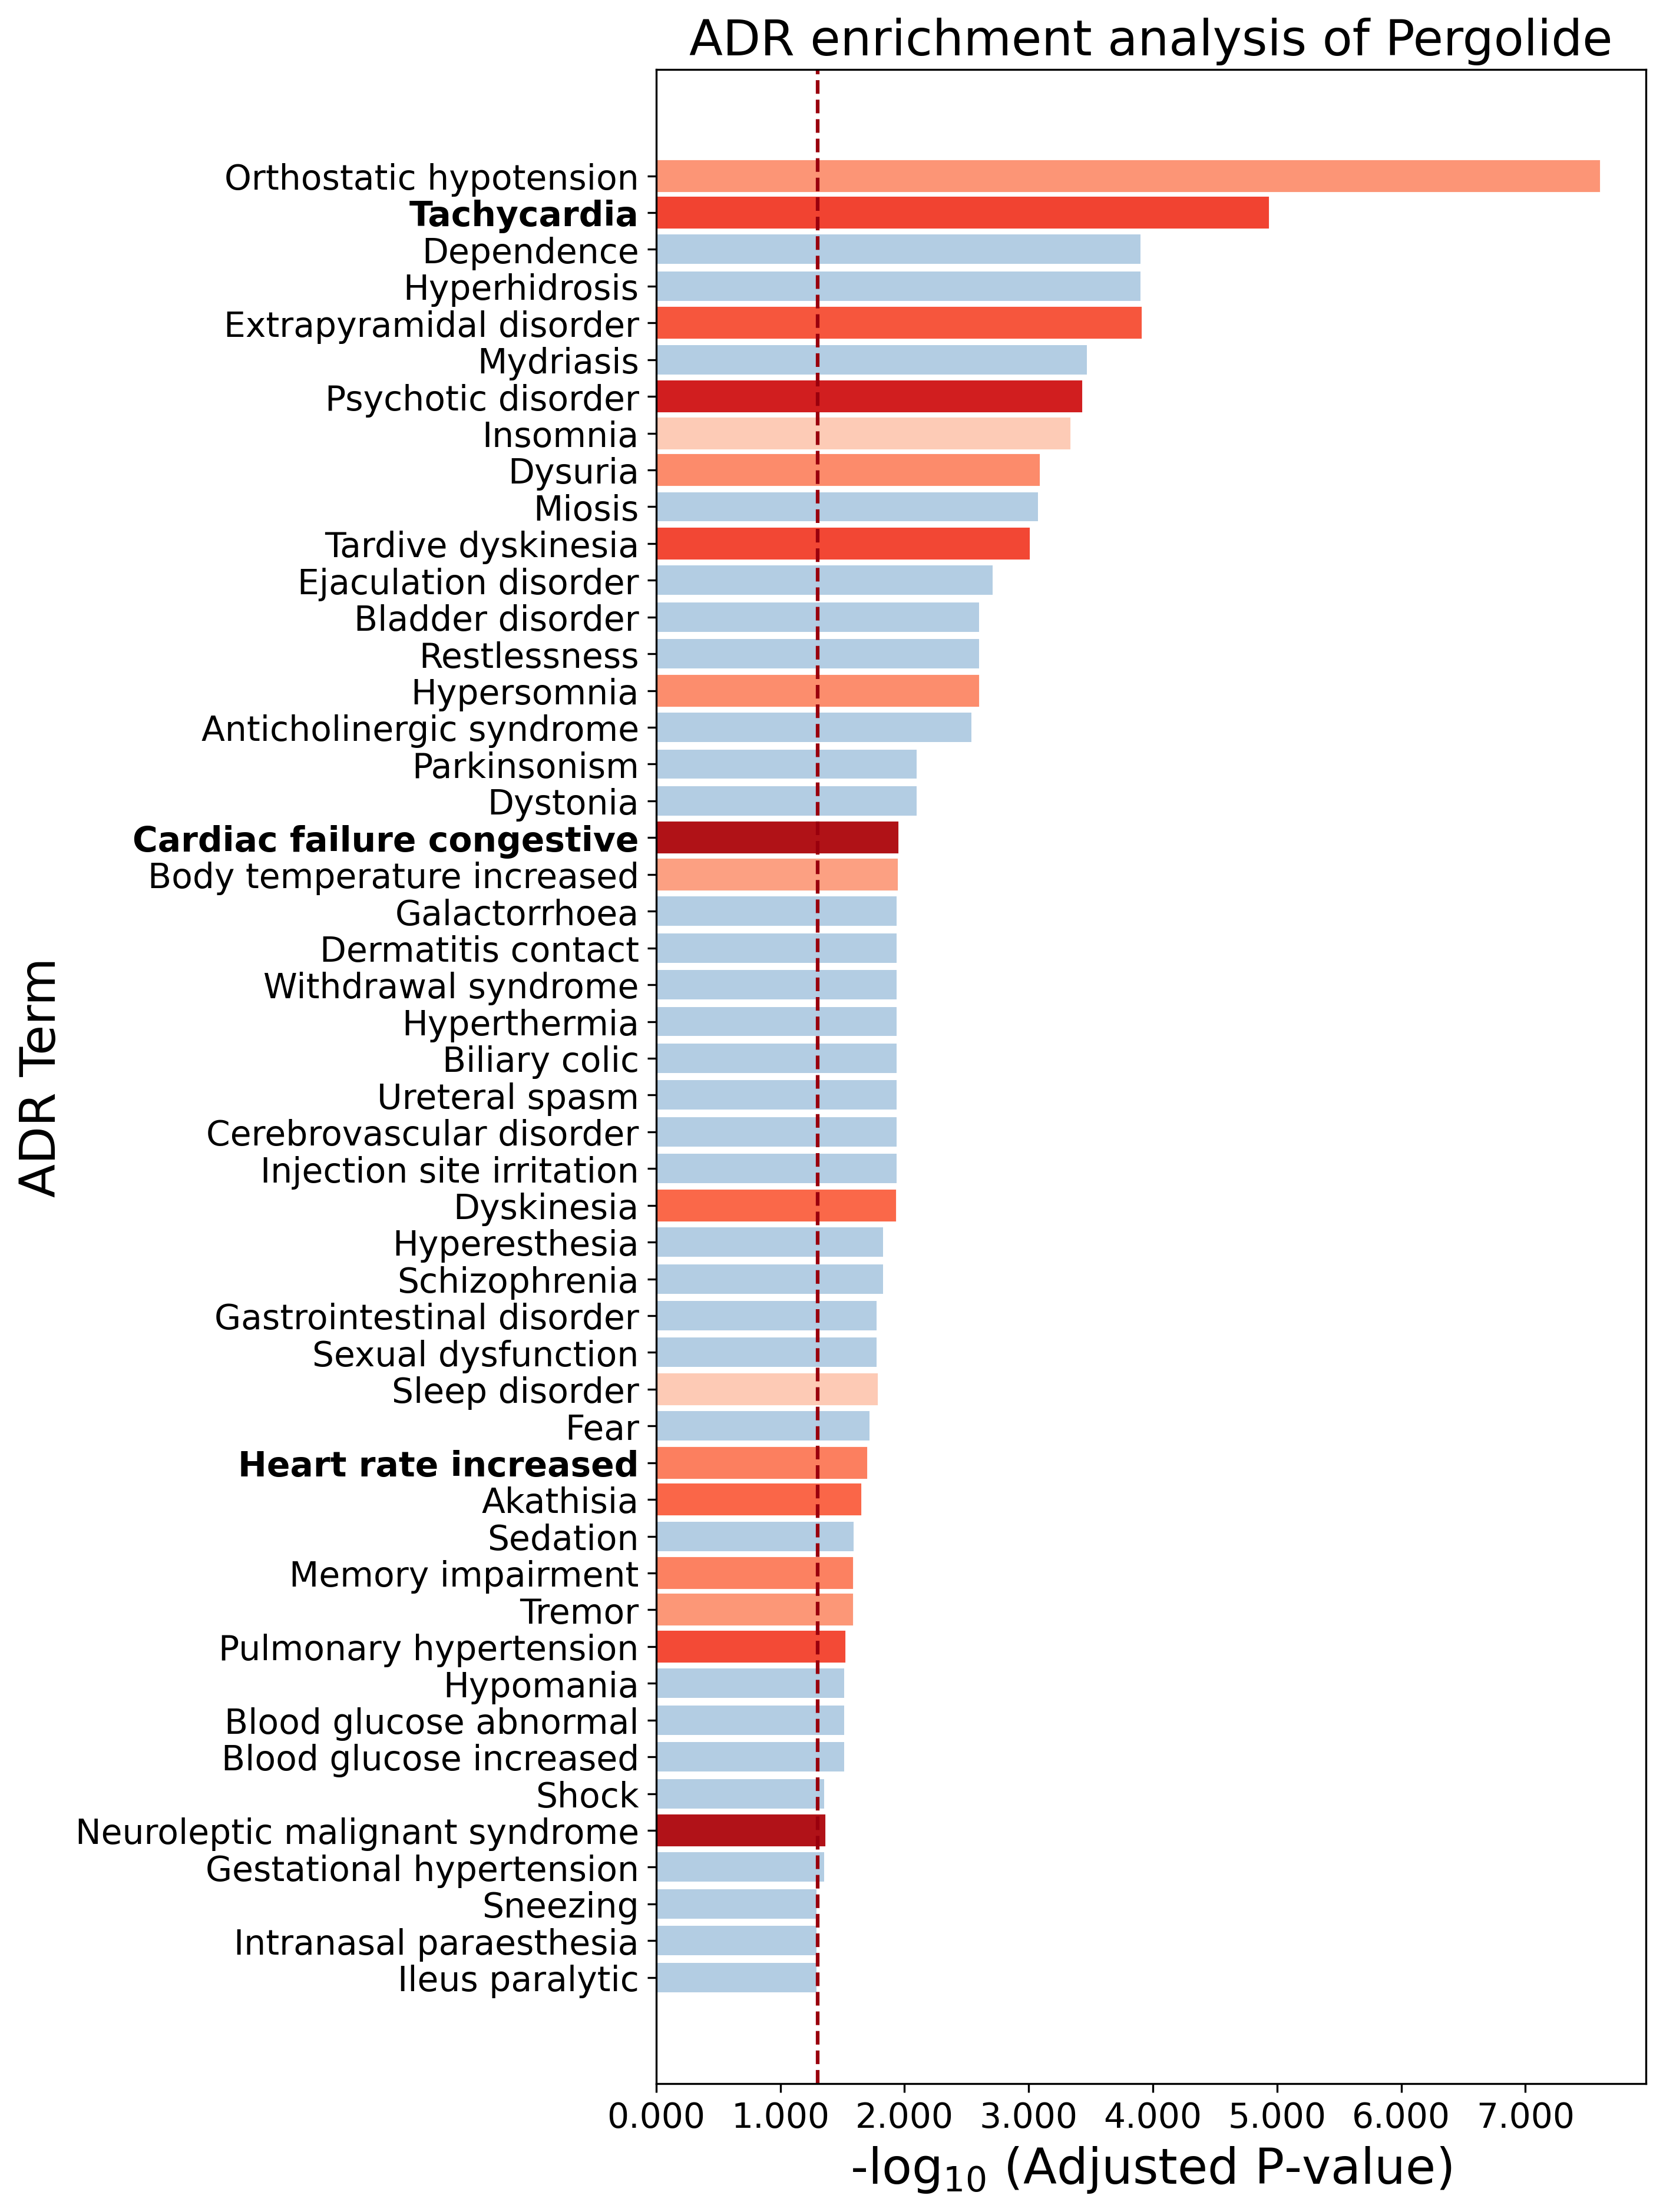

In [10]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

adr_term = adr_pergolide_pvalue_df['Term'][:50]
pvalue = adr_pergolide_pvalue_df['logp'][:50]

adr_term_sort = adr_term[::-1]
pvalue_sort = pvalue[::-1]


fig, ax = plt.subplots(figsize=(8, 6),dpi=300)
ax.barh(adr_term_sort, pvalue_sort, color='#b3cde3') 
plt.subplots_adjust(left=0.2, right=0.9, top=2.0, bottom=0.1,wspace=0.5,hspace=0.5)
indices_to_change =  [49-0,49-1,49-4,49-6,49-7,49-8,49-10,49-14,49-18,49-19,49-28,49-33,49-35,49-36,49-38,49-39,49-40,49-45]

ADR_score_indexes = [0,1,4,6,7,8,10,14,18,19,28,33,35,36,38,39,40,45] 
adr_score_choose = [adr_pergolide_pvalue_df['ADR_score'][idx] for idx in ADR_score_indexes]

# create a normalized object
norm = mcolors.Normalize(vmin=0, vmax=1)
# create a mapping object
sm = cm.ScalarMappable(cmap='Reds', norm=norm) #Reds
# get color value
colors = sm.to_rgba(adr_score_choose)

# draw bar charts
for i,color in zip(indices_to_change,colors):
    plt.gca().get_children()[i].set_color(color)

ticks = ax.yaxis.get_major_ticks()

# select part of the ticks font bold
indices_to_bold = [49-1,49-18,49-35]
for i in indices_to_bold:
    ticks[i].label1.set_weight('bold')

plt.xlabel('-log$_{10}$ (Adjusted P-value)', fontsize=20) #plt.xlabel('The size of dataset (10$^{3}$)',fontsize=20)
plt.ylabel('ADR Term', fontsize=20)
plt.title('ADR enrichment analysis of Pergolide', fontsize=20)
formatter = ticker.FormatStrFormatter('%.3f')
plt.xticks(fontsize=14)
ax.xaxis.set_major_formatter(formatter)

plt.yticks(fontsize=14)
# add a vertical dotted line
plt.axvline(x=-np.log10(0.05), color='#99000d', linestyle='--')

plt.show()

##### Sertindole

In [11]:
adr_sertindole_pvalue_df = pd.read_csv('/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/result/193target_0.3cut/adr_sertindole_pvalue.csv')

sertindole_adr_score = {}
for index, row in adr_sertindole_pvalue_df.iterrows():
    adr = row['Term']
    adr_l = adr.lower()
    try:
        score = adr_score_dict[adr_l]
    except:
        score = 0
    sertindole_adr_score[adr] = score

sertindole_adr_score['Parkinsonism'] = 0.65 

adr_sertindole_pvalue_df['ADR_score'] = adr_sertindole_pvalue_df['Term'].map(sertindole_adr_score)
adr_sertindole_pvalue_df.head(2)

,Term,Adjusted P-value,logp,ADR_score
0,Insomnia,0.001810,2.742216,0.198470
1,Ejaculation disorder,0.009454,2.024362,0.257904


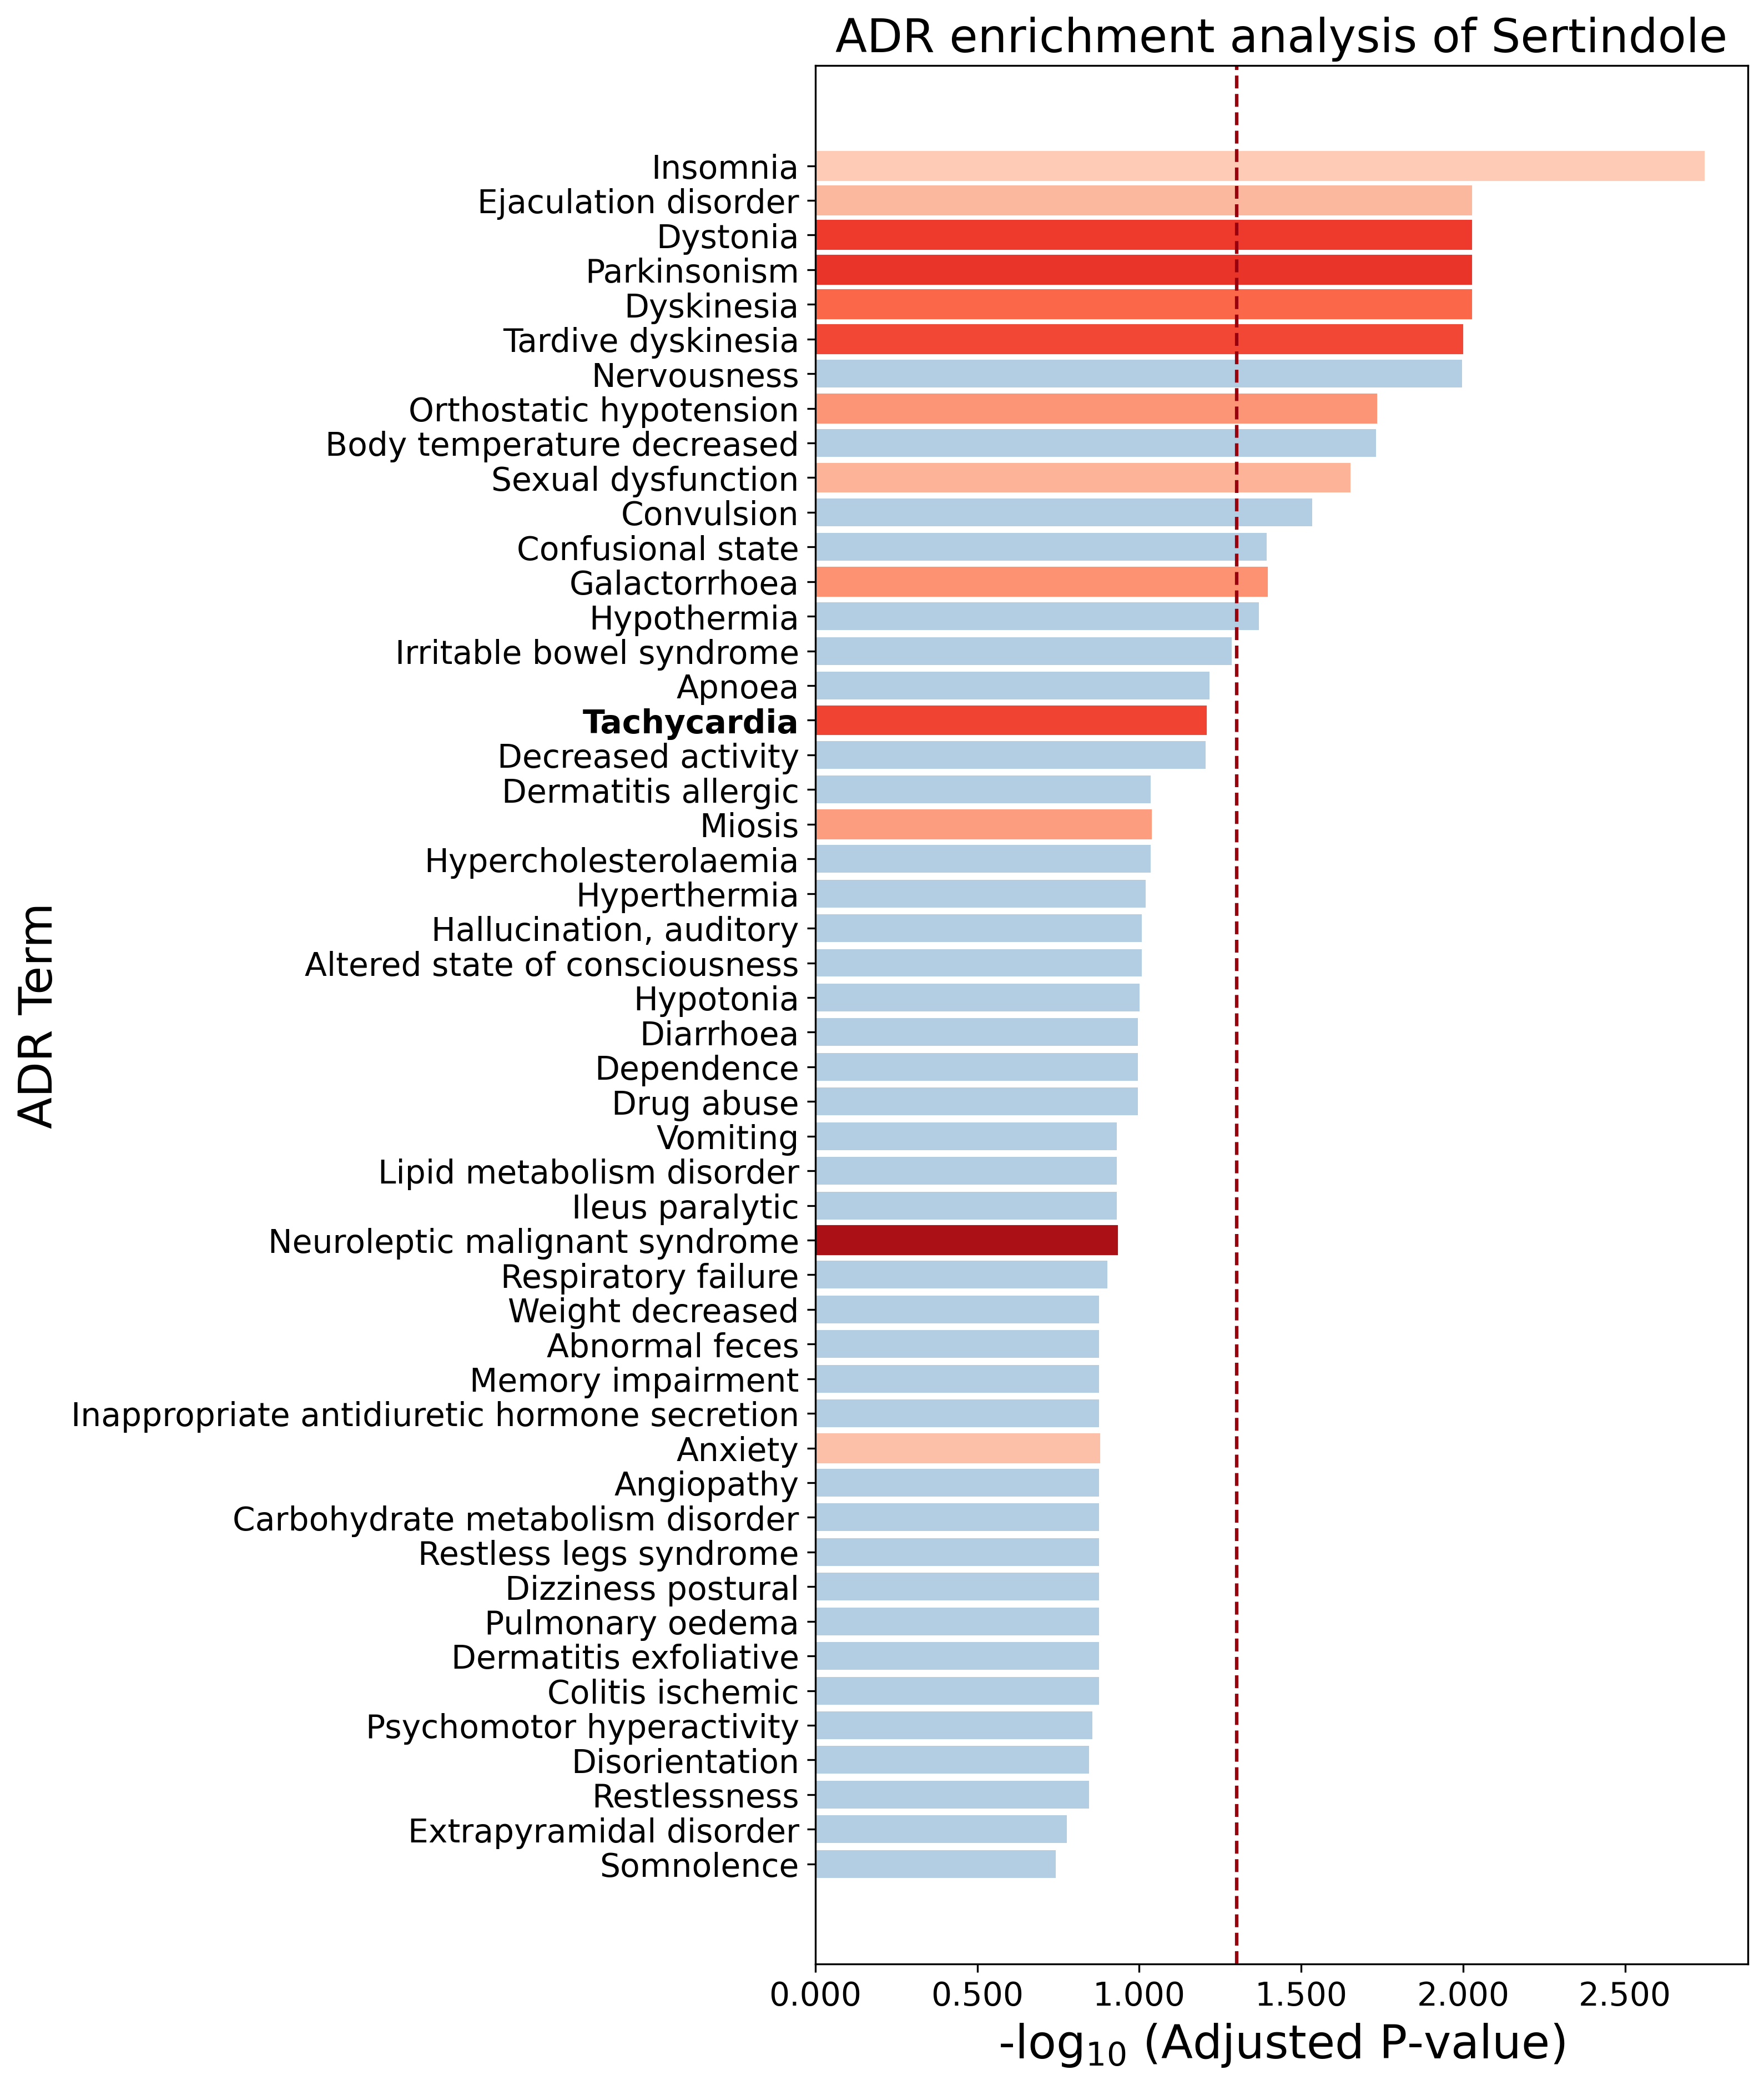

In [12]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

adr_term = adr_sertindole_pvalue_df['Term'][:50]
pvalue = adr_sertindole_pvalue_df['logp'][:50]

adr_term_sort = adr_term[::-1]
pvalue_sort = pvalue[::-1]

fig, ax = plt.subplots(figsize=(8, 6),dpi=300)
ax.barh(adr_term_sort, pvalue_sort, color='#b3cde3') 
plt.subplots_adjust(left=0.2, right=0.9, top=2.0, bottom=0.1,wspace=0.5,hspace=0.5)

indices_to_change =  [49-0,49-1,49-2,49-3,49-4,49-5,49-7,49-9,49-12,49-16,49-19,49-31,49-37] 

ADR_score_indexes = [0,1,2,3,4,5,7,9,12,16,19,32,37] 
adr_score_choose = [adr_sertindole_pvalue_df['ADR_score'][idx] for idx in ADR_score_indexes]


norm = mcolors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap='Reds', norm=norm) #Reds
colors = sm.to_rgba(adr_score_choose)

for i,color in zip(indices_to_change,colors):
    plt.gca().get_children()[i].set_color(color)
    
ticks = ax.yaxis.get_major_ticks()

indices_to_bold = [49-16,]
for i in indices_to_bold:
    ticks[i].label1.set_weight('bold')

plt.xlabel('-log$_{10}$ (Adjusted P-value)', fontsize=20) 
plt.ylabel('ADR Term', fontsize=20)
plt.title('ADR enrichment analysis of Sertindole', fontsize=20)
formatter = ticker.FormatStrFormatter('%.3f')
plt.xticks(fontsize=14)
ax.xaxis.set_major_formatter(formatter)
plt.yticks(fontsize=14)

plt.axvline(x=-np.log10(0.05), color='#99000d', linestyle='--') 
plt.show()

##### Sibutramine

In [13]:
adr_sibutramine_pvalue_df = pd.read_csv('/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/result/193target_0.3cut/adr_sibutramine_pvalue.csv')

sibutramine_adr_score = {}
for index, row in adr_sibutramine_pvalue_df.iterrows():
    adr = row['Term']
    adr_l = adr.lower()
    try:
        score = adr_score_dict[adr_l]
    except:
        score = 0
    sibutramine_adr_score[adr] = score

sibutramine_adr_score['Anticholinergic syndrome'] = 0.6
sibutramine_adr_score['Ureteral spasm'] = 0.5

adr_sibutramine_pvalue_df['ADR_score'] = adr_sibutramine_pvalue_df['Term'].map(sibutramine_adr_score)
adr_sibutramine_pvalue_df['Term_score'] = adr_sibutramine_pvalue_df['Term'] + ' ' + '(' + adr_sibutramine_pvalue_df['ADR_score'].round(3).map(str) + ')'
adr_sibutramine_pvalue_df.head(5)

,Term,Adjusted P-value,logp,ADR_score,Term_score
0,Extrapyramidal disorder,0.008162,2.088226,0.551964,Extrapyramidal disorder (0.552)
1,Cycloplegia,0.008162,2.088226,0.477830,Cycloplegia (0.478)
2,Hyperhidrosis,0.008162,2.088226,0.223636,Hyperhidrosis (0.224)
3,Shock,0.008162,2.088226,0.571372,Shock (0.571)
4,Tachycardia,0.008162,2.088226,0.603479,Tachycardia (0.603)


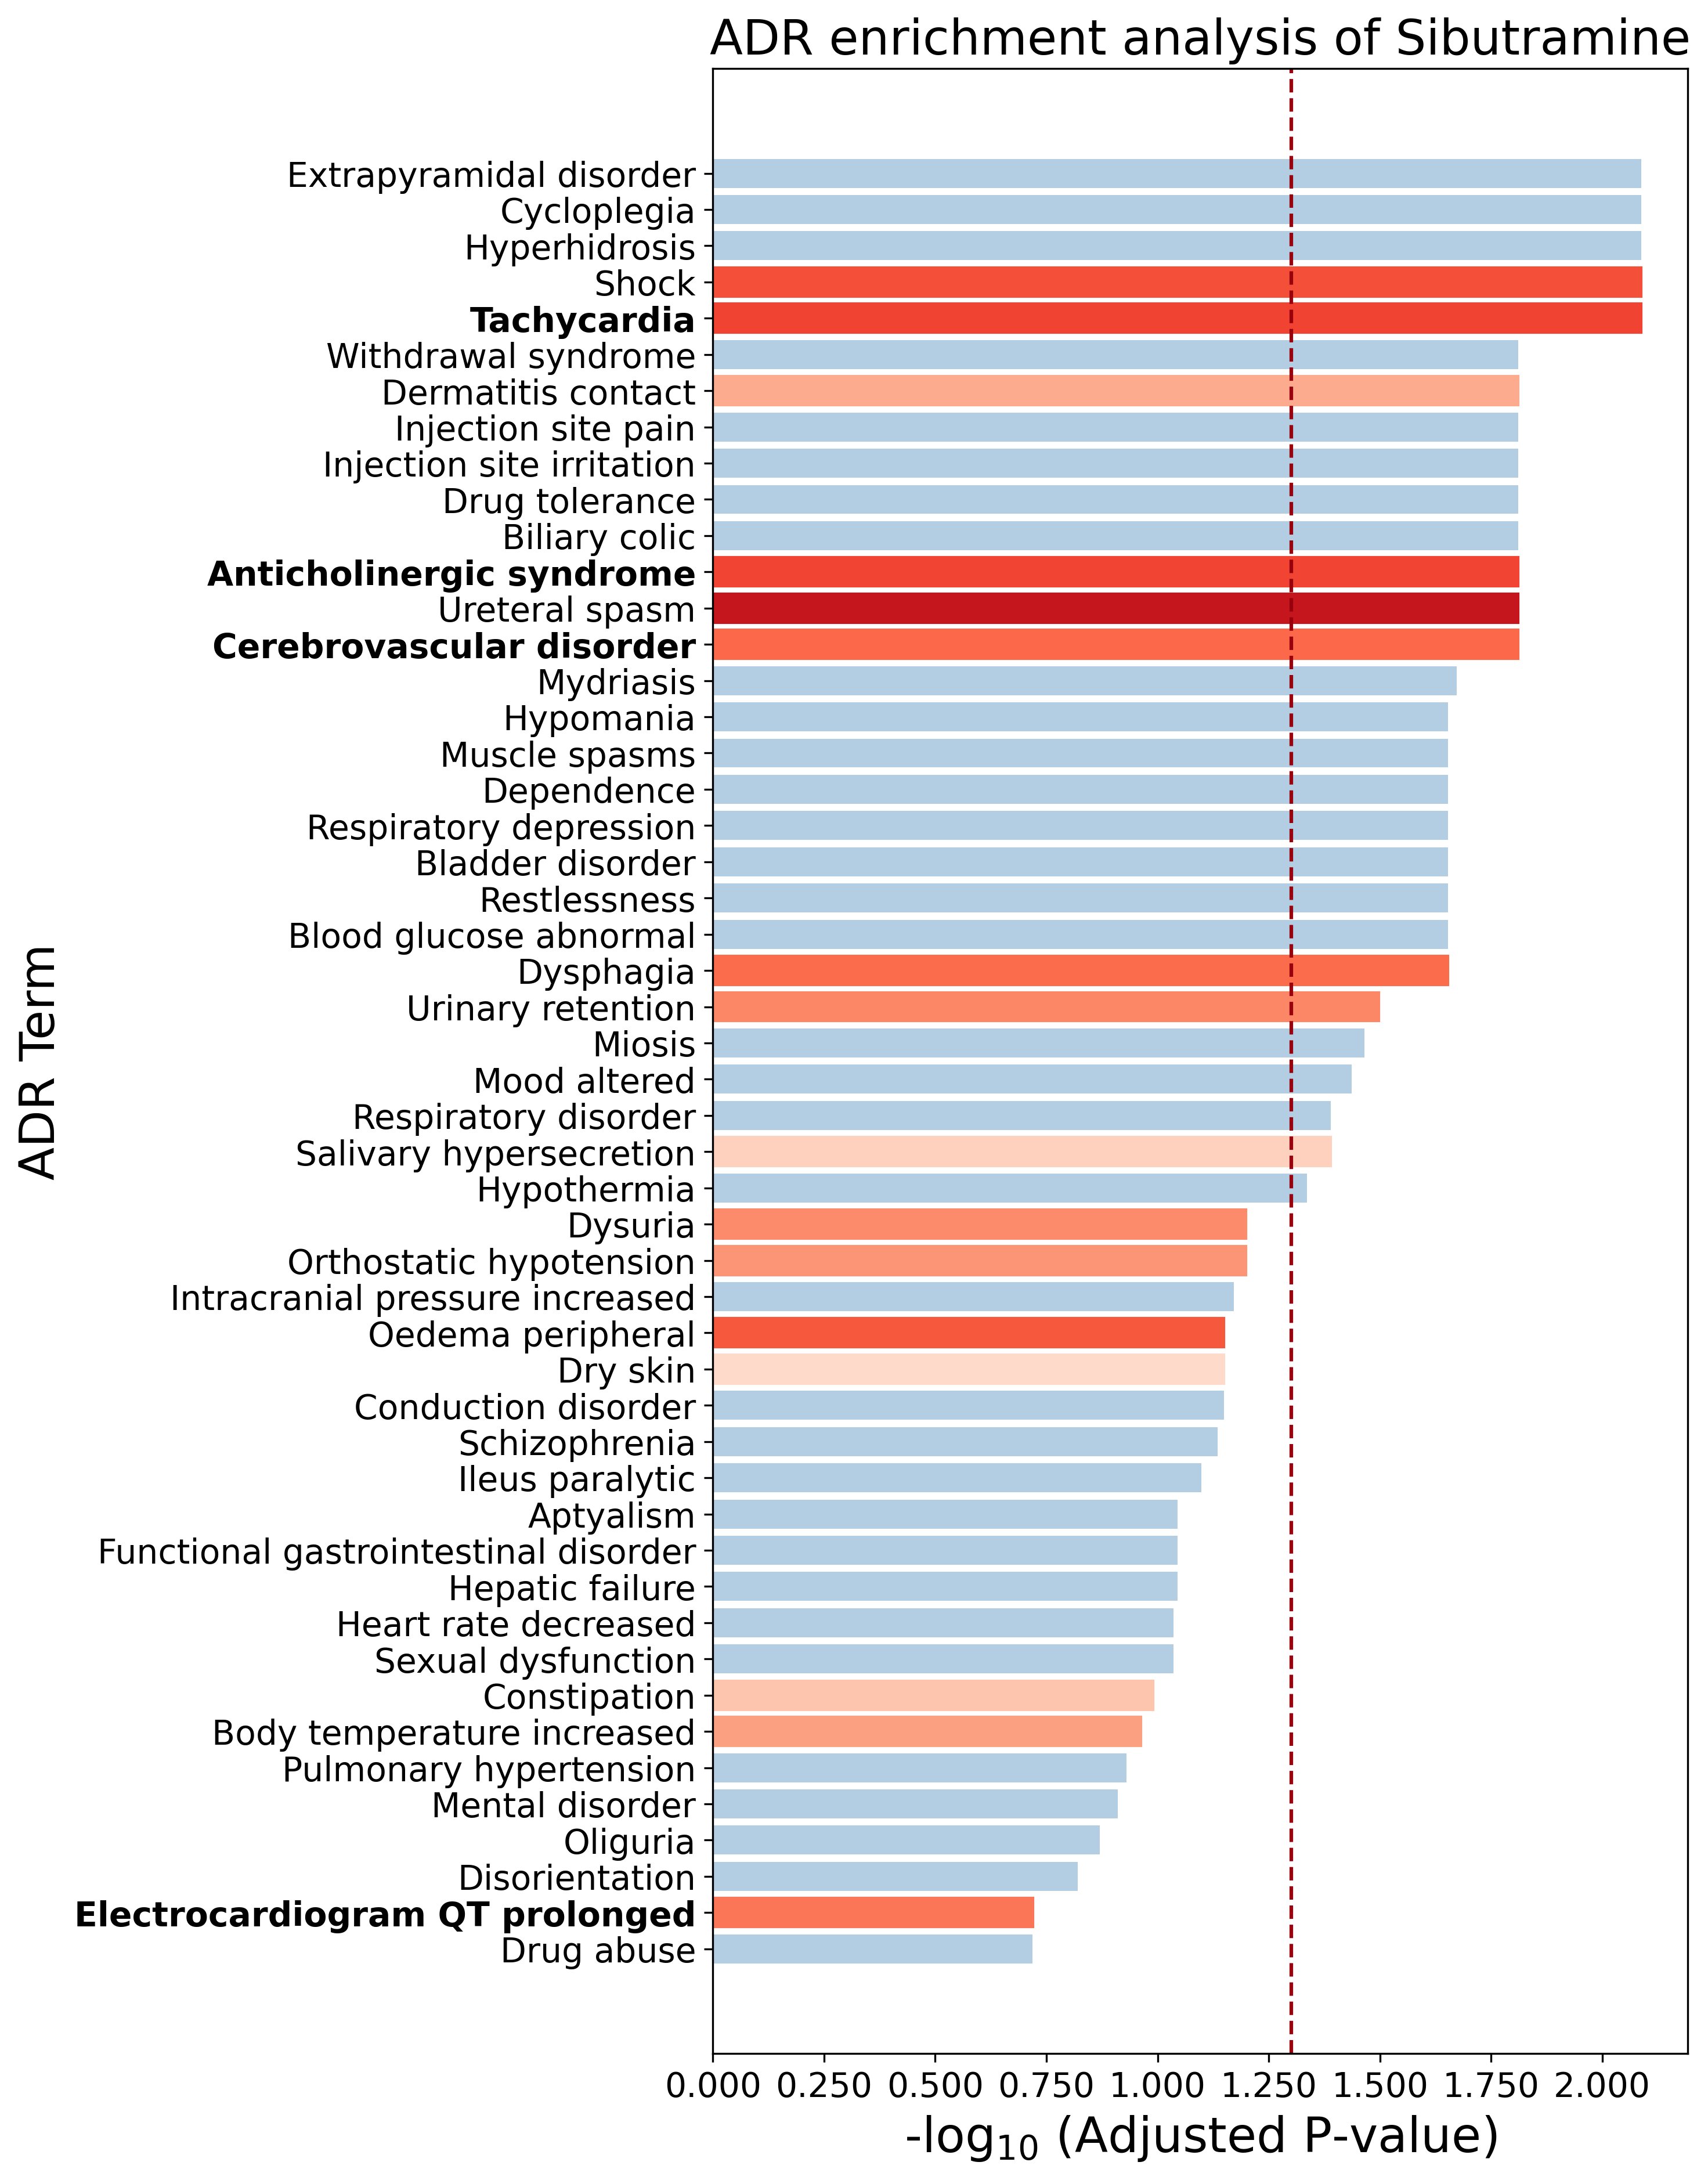

In [14]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

adr_term = adr_sibutramine_pvalue_df['Term'][:50]
pvalue = adr_sibutramine_pvalue_df['logp'][:50]

adr_term_sort = adr_term[::-1]
pvalue_sort = pvalue[::-1]

fig, ax = plt.subplots(figsize=(8, 6),dpi=300)
ax.barh(adr_term_sort, pvalue_sort, color='#b3cde3') 
plt.subplots_adjust(left=0.2, right=0.9, top=2.0, bottom=0.1,wspace=0.5,hspace=0.5)

indices_to_change =  [49-3,49-4,49-6,49-11,49-12,49-13,49-22,49-23,49-27,49-29,49-30,49-32,49-33,49-42,49-43,49-48] 
ADR_score_indexes = [3,4,6,11,13,12,22,23,27,29,30,32,33,42,43,48] 

adr_score_choose = [adr_sibutramine_pvalue_df['ADR_score'][idx] for idx in ADR_score_indexes]

norm = mcolors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap='Reds', norm=norm) #Reds
colors = sm.to_rgba(adr_score_choose)

for i,color in zip(indices_to_change,colors):
    plt.gca().get_children()[i].set_color(color)


ticks = ax.yaxis.get_major_ticks()
indices_to_bold = [49-4,49-11,49-13,49-48]
for i in indices_to_bold:
    ticks[i].label1.set_weight('bold')


plt.xlabel('-log$_{10}$ (Adjusted P-value)', fontsize=20) 
plt.ylabel('ADR Term', fontsize=20)
plt.title('ADR enrichment analysis of Sibutramine', fontsize=20)
formatter = ticker.FormatStrFormatter('%.3f')
plt.xticks(fontsize=14)
ax.xaxis.set_major_formatter(formatter)
plt.yticks(fontsize=14)
plt.axvline(x=-np.log10(0.05), color='#99000d', linestyle='--') 
plt.show()

##### Phenylpropanolamine

In [15]:
adr_phenylpropanolamine_pvalue_df = pd.read_csv('/home/liujin/Offtarget_drugsafety/offtarget_application/ADR_enrichment_analysis/result/193target_0.3cut/adr_phenylpropanolamine_pvalue.csv')

phenylpropanolamine_adr_score = {}
for index, row in adr_phenylpropanolamine_pvalue_df.iterrows():
    adr = row['Term']
    adr_l = adr.lower()
    try:
        score = adr_score_dict[adr_l]
    except:
        score = 0
    phenylpropanolamine_adr_score[adr] = score

phenylpropanolamine_adr_score['Central nervous system stimulation'] = adr_score_dict['central nervous system infection']
phenylpropanolamine_adr_score['Nervousness'] = adr_score_dict['anxiety']
phenylpropanolamine_adr_score['Neurotoxicity'] = adr_score_dict['neuromyopathy']
phenylpropanolamine_adr_score['Seizure'] = adr_score_dict['partial seizures']

adr_phenylpropanolamine_pvalue_df['ADR_score'] = adr_phenylpropanolamine_pvalue_df['Term'].map(phenylpropanolamine_adr_score)
adr_phenylpropanolamine_pvalue_df['Term_score'] = adr_phenylpropanolamine_pvalue_df['Term'] + ' ' + '(' + adr_phenylpropanolamine_pvalue_df['ADR_score'].round(3).map(str) + ')'
adr_phenylpropanolamine_pvalue_df.head(5)

,Term,Adjusted P-value,logp,ADR_score,Term_score
0,Tremor,0.000085,4.072665,0.360554,Tremor (0.361)
1,Nervousness,0.001262,2.899022,0.236358,Nervousness (0.236)
2,Cardiac arrest,0.001732,2.761562,1.000000,Cardiac arrest (1.0)
3,Myocardial depression,0.005405,2.267242,0.565722,Myocardial depression (0.566)
4,Keratitis,0.005405,2.267242,0.471728,Keratitis (0.472)


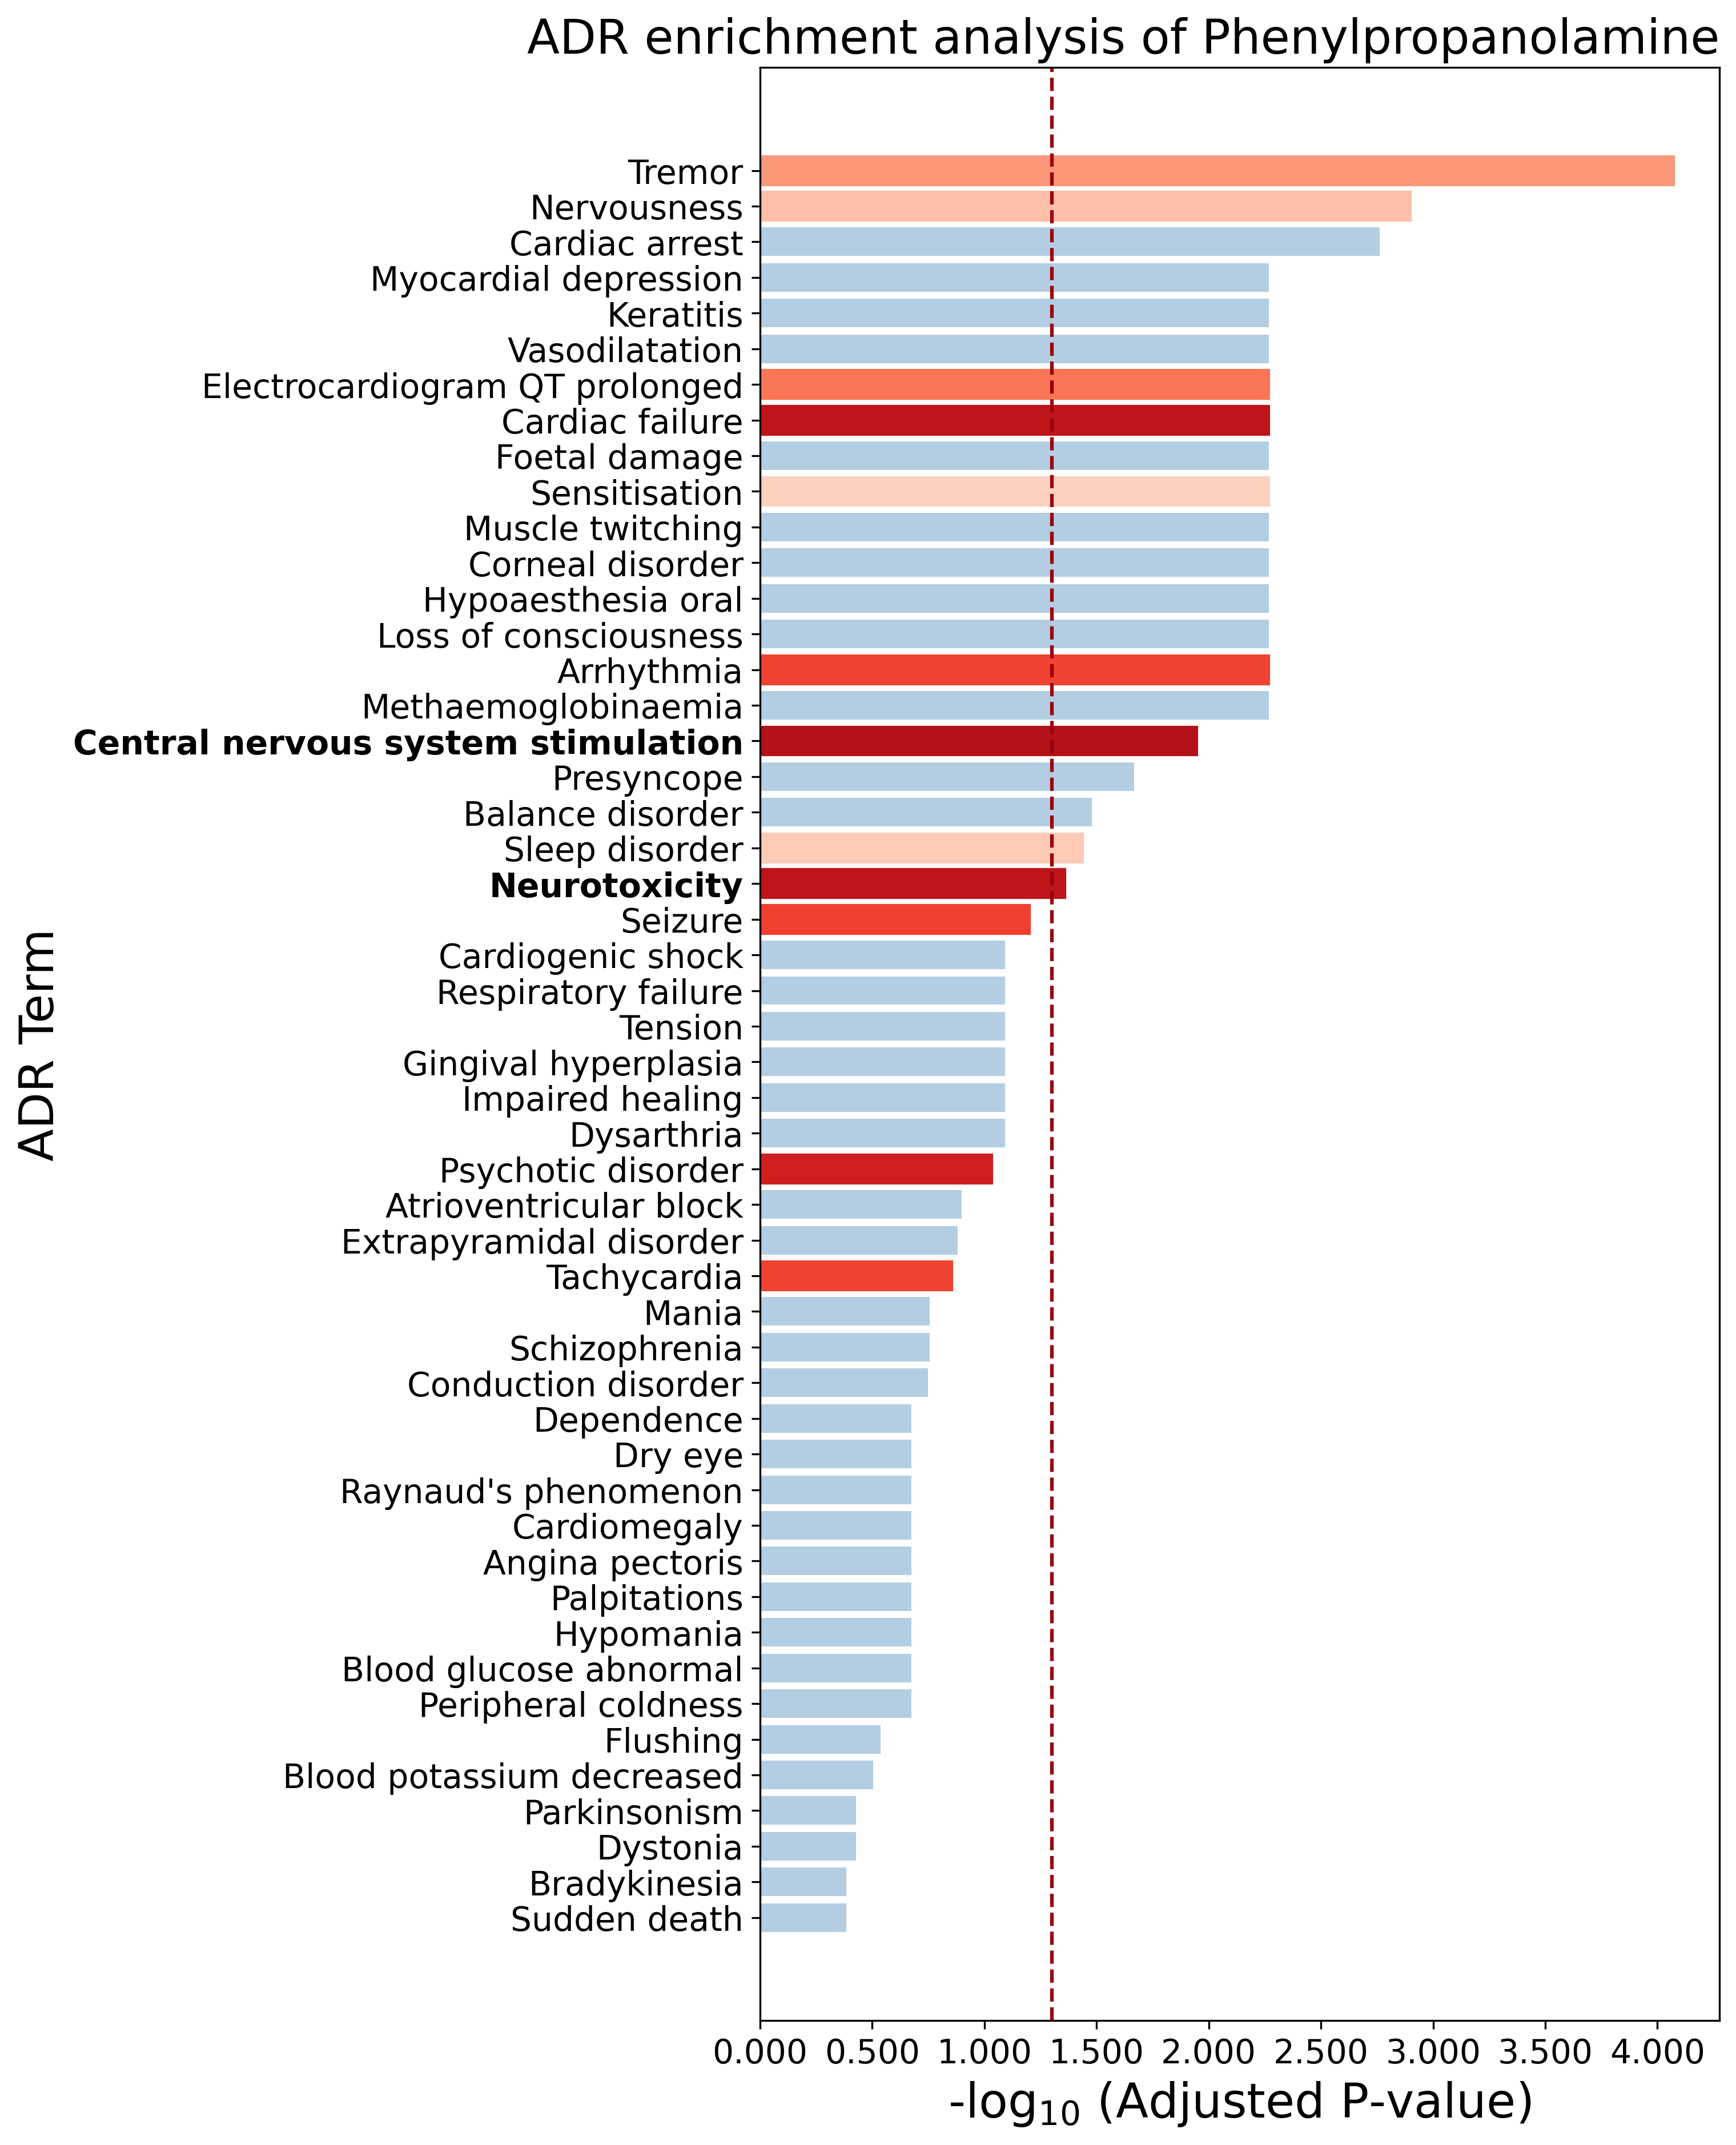

In [16]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

adr_term = adr_phenylpropanolamine_pvalue_df['Term'][:50]
pvalue = adr_phenylpropanolamine_pvalue_df['logp'][:50]

adr_term_sort = adr_term[::-1]
pvalue_sort = pvalue[::-1]

fig, ax = plt.subplots(figsize=(8, 6),dpi=300)
ax.barh(adr_term_sort, pvalue_sort, color='#b3cde3') 
plt.subplots_adjust(left=0.2, right=0.9, top=2.0, bottom=0.1,wspace=0.5,hspace=0.5)

indices_to_change =  [49-0,49-1,49-6,49-7,49-9,49-14,49-16,49-19,49-20,49-21,49-28,49-31] 
ADR_score_indexes = [0,1,6,7,9,14,16,19,20,21,28,31] 

adr_score_choose = [adr_phenylpropanolamine_pvalue_df['ADR_score'][idx] for idx in ADR_score_indexes]


norm = mcolors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap='Reds', norm=norm) 
colors = sm.to_rgba(adr_score_choose)

for i,color in zip(indices_to_change,colors):
    plt.gca().get_children()[i].set_color(color)

ticks = ax.yaxis.get_major_ticks()
indices_to_bold = [49-16,49-20]
for i in indices_to_bold:
    ticks[i].label1.set_weight('bold')

plt.xlabel('-log$_{10}$ (Adjusted P-value)', fontsize=20) 
plt.ylabel('ADR Term', fontsize=20)
plt.title('ADR enrichment analysis of Phenylpropanolamine', fontsize=20,loc='right')
formatter = ticker.FormatStrFormatter('%.3f')
plt.xticks(fontsize=14)
ax.xaxis.set_major_formatter(formatter)
plt.yticks(fontsize=14)
plt.axvline(x=-np.log10(0.05), color='#99000d', linestyle='--') 
plt.show()